# CS 5891: Final Project

### Goal: Classify images of dogs into one of 133 breeds using Transfer Learning in Pytorch

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
%cd gdrive/MyDrive/Final\ Project

/content/gdrive/MyDrive/Final Project


Install Modules

In [4]:
! pip install torch_utils

  Created wheel for torch-utils: filename=torch_utils-0.1.2-cp37-none-any.whl size=6191 sha256=1408bf64c372d704a0be6fd48bb3ada5d6320238aa7d51618b4566f4d7eb9dde
  Stored in directory: /root/.cache/pip/wheels/95/61/06/139d254fa820bc1e45087dba1d719bc7d4007aec98905179c7
Successfully built torch-utils


In [5]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import cuda
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, sampler
import torch.nn.functional as F
from torch_utils import AverageMeter
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_files 
from numpy import inf
import torchvision

from sklearn.model_selection import train_test_split
import os
from glob import glob
from torchvision import transforms
from torchvision import datasets
from torchvision import models
from torch import optim, cuda, Tensor
import tqdm

# Data science tools
import numpy as np

import os

# Image manipulations
from PIL import Image
from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt
#plt.rcParams['font.size'] = 14

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [6]:
# Define paths and parameters
traindir = f"dogImages/train"
validdir = f"dogImages/valid"
testdir = f"dogImages/test"

# Change to fit hardware
batch_size = 8

### Data Augmentation

In [7]:
# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
        transforms.Compose([
            transforms.RandomResizedCrop(256),
            transforms.RandomRotation(degrees=15),
            transforms.ColorJitter(),
            transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(size=224),  # Image net standards
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])  # Imagenet standards
        ]),
    # Validation does not use augmentation
    'valid':
        transforms.Compose([
            transforms.Resize(size=256),
            transforms.CenterCrop(size=224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    # Test data does not use augmentation
        # Validation does not use augmentation
    'test':
        transforms.Compose([
            transforms.Resize(size=256),
            transforms.CenterCrop(size=224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
}

**Show Data Augmentation**

<Figure size 720x720 with 0 Axes>

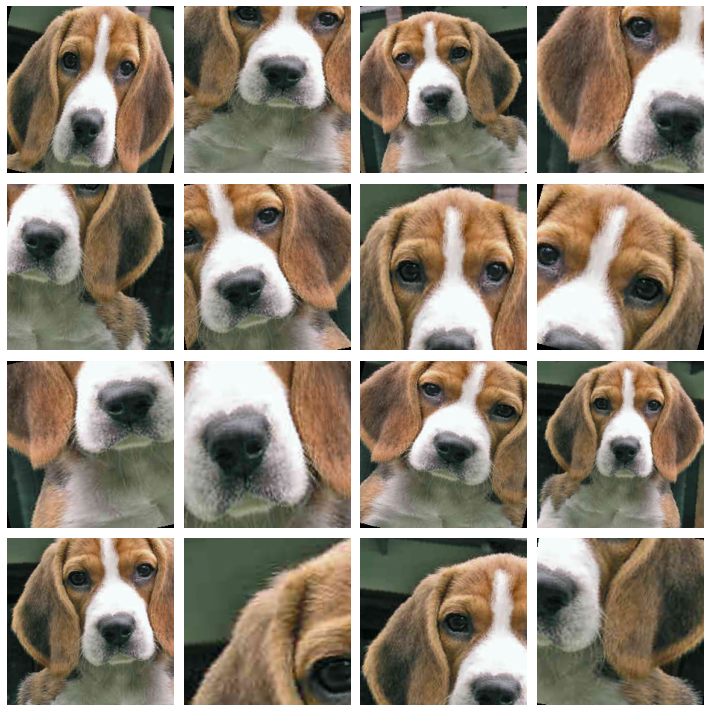

<Figure size 432x288 with 0 Axes>

In [8]:
def imshow_tensor(image, ax=None, title=None):
    """Imshow for Tensor."""

    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Clip the image pixel values
    image = np.clip(image, 0, 1)
    ax.imshow(image)
    plt.axis('off')

    return ax, image

    
ex_img = Image.open('dogImages/train/016.Beagle/Beagle_01140.jpg')

t = image_transforms['train']
plt.figure(figsize=(10, 10))

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    _ = imshow_tensor(t(ex_img), ax=ax)

plt.tight_layout()
plt.show()
plt.savefig('augmented_beagle.png')

### Load Data and Extract Images

In [9]:
# Datasets from folders
data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'valid':
    datasets.ImageFolder(root=traindir, transform=image_transforms['valid']),
    'test':
    datasets.ImageFolder(root=traindir, transform=image_transforms['test'])
}

# Dataloader iterators, make sure to shuffle
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True,num_workers=10),
    'val': DataLoader(data['valid'], batch_size=batch_size, shuffle=True,num_workers=10),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True,num_workers=10)
}

# Iterate through the dataloader once
trainiter = iter(dataloaders['train'])
validationiter = iter(dataloaders['val'])
testiter = iter(dataloaders['test'])

categories = []
for d in os.listdir(traindir):
    categories.append(d)

n_classes = len(categories) 
print(f'There are {n_classes} different classes.')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


There are 133 different classes.


### Dog Detector
In this section, I use a pre-trained model to detect dogs in images. The model has been pre-trained on Imagenet. 

In [131]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
cuda.empty_cache()

# Define the network with pretrained model from imagenet
dog_model = models.resnet50(pretrained=True) 

In [11]:
# Check whether there is a gpu for cuda
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False
else:
    multi_gpu = False
print(train_on_gpu,multi_gpu)

if train_on_gpu:
    dog_model = dog_model.to('cuda')

Train on gpu: True
1 gpus detected.
True False


In [12]:
# Read classes of ImageNet
with open('imagenet_classes.txt') as f:
  classes = [line.strip() for line in f.readlines()]

In [13]:
def ResNet50_predict(data_path):
  '''
  Use pre-trained ResNet50 model to obtain index corresponding to 
  predicted ImageNet class for image at specified path
  Args:
      data_path: path to an image    
  Returns:
      Index corresponding to VGG-16 model's prediction
  '''
  # Pre-Process Data
  img_t = image_transforms['test'](Image.open(data_path))
  batch_t = torch.unsqueeze(img_t, 0)

  if train_on_gpu:
    batch_t = batch_t.cuda()
  out = dog_model(batch_t)

  # Get index of classification 
  _, index = torch.max(out, 1)
  # percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
  return index[0]

def dog_detector(data_path):
  '''
  Uses ResNet50 predictor to determine if the corresponding
  ImageNet class for image at specified path is a dog
  Args:
    data_path: path to an image
  Returns:
    True if classified as a dog, False for other classifications
  '''
  pred = ResNet50_predict(data_path)
  return (pred <= 268) and (pred >= 151)

# Set model to evaluation mode
dog_model.eval()

# filename = 'dogImages/test/016.Beagle/Beagle_01197.jpg'

path = 'dogImages/test/'
listOfDir = os.listdir(path)
totalFiles = 0
notDogs = 0
for subdir in listOfDir:
  files = os.listdir(path + subdir)
  for filename in files:
    totalFiles += 1 
    if not dog_detector(path + subdir + '/' + filename):
      notDogs += 1
      print("%s was not correctly identified as a dog." % (filename))

print("ImageNet classified %d images. %d were correctly classified as dogs." % (totalFiles, totalFiles - notDogs))
print("ResNet50 Top-1 Error %d%% for images of dogs" % (((totalFiles - notDogs) / totalFiles) * 100))

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Parson_russell_terrier_07529.jpg was not correctly identified as a dog.
Norwegian_buhund_07120.jpg was not correctly identified as a dog.
Norwegian_buhund_07111.jpg was not correctly identified as a dog.
Akita_00276.jpg was not correctly identified as a dog.
Akita_00262.jpg was not correctly identified as a dog.
Norwegian_lundehund_07222.jpg was not correctly identified as a dog.
Australian_cattle_dog_00728.jpg was not correctly identified as a dog.
Australian_cattle_dog_00761.jpg was not correctly identified as a dog.
Australian_cattle_dog_00792.jpg was not correctly identified as a dog.
Canaan_dog_03066.jpg was not correctly identified as a dog.
Canaan_dog_03073.jpg was not correctly identified as a dog.
Canaan_dog_03084.jpg was not correctly identified as a dog.
ImageNet classified 835 images. 823 were correctly classified as dogs.
ResNet50 Top-1 Error 98% for images of dogs


## Baseline Model (HW 4) 

CNN consists of three convolutional layers, where each convolutional layer is followed by a max pooling layer and one ReLU layer. This used a kernel size of 3 and a stride of 1. The max pooling layer used a kernel size of 2 and a stride of 1. 

Three fully connected layers followed the convolutional layers, which resulted in 133 output neurons that allowed us to classify the images into 133 categories (breeds) using one-hot encoding. 

In [14]:
# Define model
class dmodel(nn.Module):
    def __init__(self):
        super(dmodel, self).__init__()
        
        # 2D Convolutional Neural Network
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(16 * 53 * 53, 4096)
        self.fc2 = nn.Linear(4096, 1024)
        self.fc3 = nn.Linear(1024, 133)

    def forward(self, x):
        # Convolutional Layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 53 * 53)

        # Fully Connected Layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

scratch_model = dmodel()

In [19]:
# Set model to GPU
if train_on_gpu:
    scratch_model = scratch_model.to('cuda')

# Set up your criterion and optimizer
learning_rate = 1e-4
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr = learning_rate)
scratch_criterion = nn.CrossEntropyLoss()

In [20]:
# For results
print(scratch_model)

dmodel(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=44944, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=133, bias=True)
)


#### Training the CNN Model

In [21]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=10,
          print_every=1):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0
       

        # Set to training
        model.train()
        
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            
            # Tensors to gpu  
            if train_on_gpu:
                model = model.cuda()
                data, target = data.cuda(), target.cuda()
           

            # Clear gradients
            optimizer.zero_grad()

            # Get your output from your model
            model = model.float()
            output = model(data.float())

            # Loss and backpropagation of gradients
            loss = criterion(output, target.long())
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch        
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability 
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))

            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor)) 

            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():

                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:

                    # Tensors to gpu
                    if train_on_gpu:
                        model = model.cuda()
                        data, target = data.cuda(), target.cuda()
                    
                    # Forward pass                    
                    model = model.float()
                    output = model(data.float())
                    
                    # Validation loss
                    loss = criterion(output, target.long())
                    
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)
                    
                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)
                    

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)
                

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)
                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict                        
                        model.load_state_dict(torch.load(save_file_name))
                        
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_best_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [16]:
from timeit import default_timer as timer
save_file_name = f'CNN_scratch_model.pt'
train_on_gpu = cuda.is_available()

scratch_model, scratch_history = train(scratch_model,
    scratch_criterion,
    scratch_optimizer,
    dataloaders['train'], 
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=5,
    n_epochs=500,
    print_every=1)

Starting Training from Scratch.



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch: 0 	Training Loss: 4.8906 	Validation Loss: 4.8900
		Training Accuracy: 0.81%	 Validation Accuracy: 0.73%

Epoch: 1 	Training Loss: 4.8897 	Validation Loss: 4.8889
		Training Accuracy: 0.82%	 Validation Accuracy: 0.72%

Epoch: 2 	Training Loss: 4.8883 	Validation Loss: 4.8877
		Training Accuracy: 0.97%	 Validation Accuracy: 0.81%

Epoch: 3 	Training Loss: 4.8874 	Validation Loss: 4.8865
		Training Accuracy: 0.99%	 Validation Accuracy: 0.88%

Epoch: 4 	Training Loss: 4.8861 	Validation Loss: 4.8851
		Training Accuracy: 1.09%	 Validation Accuracy: 0.88%

Epoch: 5 	Training Loss: 4.8849 	Validation Loss: 4.8837
		Training Accuracy: 0.99%	 Validation Accuracy: 0.94%

Epoch: 6 	Training Loss: 4.8832 	Validation Loss: 4.8821
		Training Accuracy: 0.99%	 Validation Accuracy: 1.09%

Epoch: 7 	Training Loss: 4.8821 	Validation Loss: 4.8803
		Training Accuracy: 1.05%	 Validation Accuracy: 1.23%

Epoch: 8 	Training Loss: 4.8802 	Validation Loss: 4.8782
		Training Accuracy: 1.21%	 Validation

#### Training and Validation Losses

In [55]:
save_file_name = f'CNN_scratch_model.pt'

# Load saved model due to Colab timeout
scratch_model.load_state_dict(torch.load(save_file_name))
scratch_model.eval()

<All keys matched successfully>

dmodel(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=44944, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=133, bias=True)
)

In [75]:
epoch = []
training_loss = []
validation_loss = []
training_accuracy = []
validation_accuracy = []

# Open results file
file1 = open('scratch_results.txt', 'r')

# Parse lines of text
while True:
  # Line 1: Epoch, Trainging Loss, Validation Loss
  line1 = file1.readline()

  # Line 2: Trainging Accuracy, Validation Accuracy 
  line2 = file1.readline()

  # End of file
  if not line2:
    break

  # Line 3: Empty line
  line3 = file1.readline()
  line3 = line3.strip()

  # Get data
  line1 = line1.strip().split('\t')
  epoch.append(int((line1[0].replace('Epoch: ', '')).strip()))
  training_loss.append(float((line1[1].replace('Training Loss: ', '')).strip()))
  validation_loss.append(float((line1[2].replace('Validation Loss: ', '')).strip()))

  line2 = line2.strip().split('\t')
  training_accuracy.append(float(((line2[0].replace('Training Accuracy: ', '')).strip()).replace('%', '')))
  validation_accuracy.append(float((line2[1].replace('Validation Accuracy: ', '')).strip().replace('%', '')))


<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Negative Log Likelihood')

Text(0.5, 1.0, 'Training and Validation Losses')

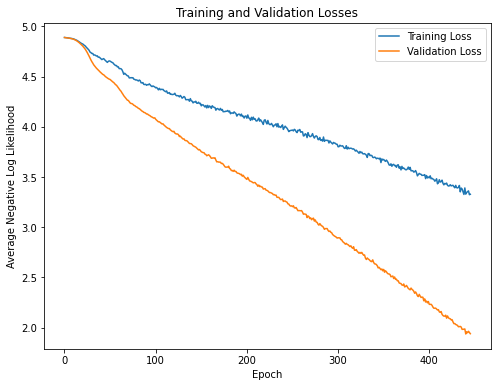

<Figure size 432x288 with 0 Axes>

In [79]:
plt.figure(figsize=(8, 6))
plt.plot(epoch, training_loss, label = 'Training Loss')
plt.plot(epoch, validation_loss, label = 'Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')
plt.show()
plt.savefig('sratch_loss.png')

#### Training and Validation Accuracy

<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Accuracy')

Text(0.5, 1.0, 'Training and Validation Accuracy')

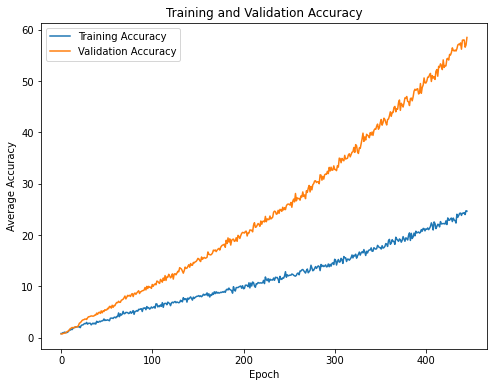

In [80]:
plt.figure(figsize=(8, 6))
plt.plot(epoch, training_accuracy, label = 'Training Accuracy')
plt.plot(epoch, validation_accuracy, label = 'Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

### Testing

In [128]:
# Run test data through model 
def test(model, criterion, optimizer, test_loader, train_on_gpu):

    # Test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # Set model to evaluation mode
    model.eval()
    for batch_idx, (data, target) in enumerate(test_loader):
        # Set tensors to GPU
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)

        # Calculate the loss
        loss = criterion(output, target)

        # Update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))

        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(scratch_model, scratch_criterion, scratch_optimizer, dataloaders['test'], train_on_gpu)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Test Loss: 1.936387


Test Accuracy: 57% (3873/6680)


In [194]:
def wrong(data_path):
  # Pre-Process Data
  img_t = image_transforms['test'](Image.open(data_path).convert('RGB'))
  batch_t = torch.unsqueeze(img_t, 0)

  if train_on_gpu:
    batch_t = batch_t.cuda()
  out = scratch_model(batch_t)

  # Get index of classification 
  # _, index = torch.max(out, 1)
  index = out.data.max(1, keepdim=True)[1]
  percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
  return index[0] + 1, percentage

path = 'dogImages/test/'
listOfDir = os.listdir(path)
totalFiles = 0
wrongDogs = 0
breeds = {} # Dictionary of breeds
for subdir in listOfDir:
  files = os.listdir(path + subdir)
  subdir_str = subdir.split('.')
  key = int(subdir_str[0].strip())
  value = subdir_str[1].strip()
  breeds[key] = value
  # print(subdir_str)
  for filename in files:
    totalFiles += 1 
    dogBreed, _ = wrong(path + subdir + '/' + filename)
    if dogBreed != key:
      print("Actual: %s \tPredicted: %d" % (key, dogBreed))
      wrongDogs += 1

print("ResNet50 Top-1 Error %d%% for breeds of dogs" % (((totalFiles - wrongDogs) / totalFiles) * 100))
print("Correctly classified: %d / %d" % ((totalFiles - wrongDogs), totalFiles))

Actual: 90 	Predicted: 43
Actual: 90 	Predicted: 68
Actual: 90 	Predicted: 4
Actual: 90 	Predicted: 74
Actual: 90 	Predicted: 21
Actual: 90 	Predicted: 62
Actual: 90 	Predicted: 37
Actual: 90 	Predicted: 117
Actual: 95 	Predicted: 37
Actual: 95 	Predicted: 89
Actual: 95 	Predicted: 99
Actual: 95 	Predicted: 42
Actual: 95 	Predicted: 94
Actual: 95 	Predicted: 124
Actual: 116 	Predicted: 131
Actual: 116 	Predicted: 7
Actual: 116 	Predicted: 62
Actual: 116 	Predicted: 31
Actual: 92 	Predicted: 109
Actual: 92 	Predicted: 94
Actual: 92 	Predicted: 94
Actual: 92 	Predicted: 40
Actual: 92 	Predicted: 75
Actual: 21 	Predicted: 22
Actual: 21 	Predicted: 68
Actual: 21 	Predicted: 29
Actual: 21 	Predicted: 29
Actual: 21 	Predicted: 68
Actual: 21 	Predicted: 109
Actual: 21 	Predicted: 93
Actual: 100 	Predicted: 80
Actual: 100 	Predicted: 94
Actual: 100 	Predicted: 74
Actual: 100 	Predicted: 17
Actual: 12 	Predicted: 64
Actual: 12 	Predicted: 36
Actual: 12 	Predicted: 98
Actual: 12 	Predicted: 83
A

## Pretrained Model (HW 5)

In [150]:
# Freeze model weights
# You need to go throught all the parameters in model.parameters()
# You need to set "requires_grad" to "False" for all parameters
for param in dog_model.parameters():
  param.requires_grad = False

# You may get the number of the features from the feature layer of the pretrained network
# You can use model.fc.in_features to get the feature number
# n_inputs = dog_model.fc.in_features

dog_model.fc = nn.Linear(n_inputs, n_classes, bias=True)

# = nn.Sequential(
#                       # Define the last block of the nework for our dataset.
#                       # This block may have two linear layers, one dropout layer, and one softmax layer.
#                       # You may design your own classifier with a discription.
#                       nn.Linear(n_inputs, 256),
#                       nn.ReLU(),
#                       nn.Dropout(0.4),
#                       nn.Linear(256, n_classes),
#                       nn.LogSoftmax(dim=1))
dog_model.fc

total_params = sum(p.numel() for p in dog_model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in dog_model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

Linear(in_features=2048, out_features=133, bias=True)

23,780,549 total parameters.
272,517 training parameters.


In [151]:
# Check whether there is a gpu for cuda
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False
else:
    multi_gpu = False
print(train_on_gpu,multi_gpu)

if train_on_gpu:
    dog_model = dog_model.to('cuda')

Train on gpu: True
1 gpus detected.
True False


Set up hyper parameters for our network. 

In [152]:
dog_model.class_to_idx = data['train'].class_to_idx
dog_model.idx_to_class = {
    idx: class_
    for class_, idx in dog_model.class_to_idx.items()
}

list(dog_model.idx_to_class.items())


# Set up your criterion and optimizer
dog_criterion = nn.CrossEntropyLoss()
dog_optimizer = optim.Adam(dog_model.parameters(), lr = 0.001)

for p in dog_optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)

[(0, '001.Affenpinscher'),
 (1, '002.Afghan_hound'),
 (2, '003.Airedale_terrier'),
 (3, '004.Akita'),
 (4, '005.Alaskan_malamute'),
 (5, '006.American_eskimo_dog'),
 (6, '007.American_foxhound'),
 (7, '008.American_staffordshire_terrier'),
 (8, '009.American_water_spaniel'),
 (9, '010.Anatolian_shepherd_dog'),
 (10, '011.Australian_cattle_dog'),
 (11, '012.Australian_shepherd'),
 (12, '013.Australian_terrier'),
 (13, '014.Basenji'),
 (14, '015.Basset_hound'),
 (15, '016.Beagle'),
 (16, '017.Bearded_collie'),
 (17, '018.Beauceron'),
 (18, '019.Bedlington_terrier'),
 (19, '020.Belgian_malinois'),
 (20, '021.Belgian_sheepdog'),
 (21, '022.Belgian_tervuren'),
 (22, '023.Bernese_mountain_dog'),
 (23, '024.Bichon_frise'),
 (24, '025.Black_and_tan_coonhound'),
 (25, '026.Black_russian_terrier'),
 (26, '027.Bloodhound'),
 (27, '028.Bluetick_coonhound'),
 (28, '029.Border_collie'),
 (29, '030.Border_terrier'),
 (30, '031.Borzoi'),
 (31, '032.Boston_terrier'),
 (32, '033.Bouvier_des_flandres'),


torch.Size([133, 2048])
torch.Size([133])


### Training Process

Experiment 1: Early stop after 5 epochs, 500 epochs possible, lr = 1e-3

Experiment 2: Continue training after 46 epochs, early stop after 10 epochs, 500 epochs possible, lr = 1e-3

Experiment 3: Continue training after 77 epochs, early stop after 5 epochs, 500 epochs possible, lr = 1e-4

Experiment 4: Continue trainging after 86 epochs, lr = 1e-5

Experiment 5: Continue training after 99 epochs, lr = 1e-3, output layer only has one linear layer now



In [153]:
from timeit import default_timer as timer
save_file_name = f'resnet-50_model_best_model.pt'
train_on_gpu = cuda.is_available()

model, history = train(dog_model,
    dog_criterion,
    dog_optimizer,
    dataloaders['train'], 
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=5,
    n_epochs=500,
    print_every=1)

Model has been trained for: 99 epochs.



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch: 0 	Training Loss: 3.1907 	Validation Loss: 0.8021
		Training Accuracy: 30.12%	 Validation Accuracy: 75.21%

Epoch: 1 	Training Loss: 1.9865 	Validation Loss: 0.6660
		Training Accuracy: 49.19%	 Validation Accuracy: 79.51%

Epoch: 2 	Training Loss: 1.8975 	Validation Loss: 0.5720
		Training Accuracy: 51.90%	 Validation Accuracy: 82.11%

Epoch: 3 	Training Loss: 1.8235 	Validation Loss: 0.5092
		Training Accuracy: 55.24%	 Validation Accuracy: 83.97%

Epoch: 4 	Training Loss: 1.8534 	Validation Loss: 0.4722
		Training Accuracy: 56.14%	 Validation Accuracy: 84.94%

Epoch: 5 	Training Loss: 1.7519 	Validation Loss: 0.4643
		Training Accuracy: 57.68%	 Validation Accuracy: 85.69%

Epoch: 6 	Training Loss: 1.7591 	Validation Loss: 0.4544
		Training Accuracy: 58.61%	 Validation Accuracy: 86.09%

Epoch: 7 	Training Loss: 1.7512 	Validation Loss: 0.4770
		Training Accuracy: 59.40%	 Validation Accuracy: 85.78%

Epoch: 8 	Training Loss: 1.7475 	Validation Loss: 0.3884
		Training Accuracy: 5

### Training and Validation Losses

<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Negative Log Likelihood')

Text(0.5, 1.0, 'Training and Validation Losses')

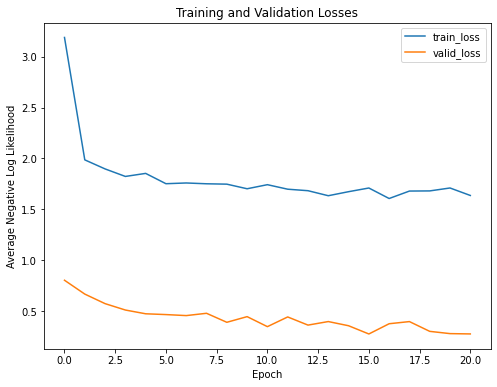

In [154]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')
plt.show()

### Training and Validation Accuracy 

<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Accuracy')

Text(0.5, 1.0, 'Training and Validation Accuracy')

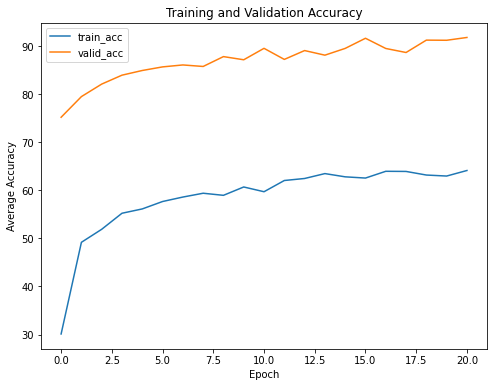

In [155]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

In [156]:
test(dog_model, dog_criterion, dog_optimizer, dataloaders['test'], train_on_gpu)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Test Loss: 0.273531


Test Accuracy: 91% (6122/6680)


## Predictions

In [157]:
print(breeds)

{90: 'Italian_greyhound', 95: 'Kuvasz', 116: 'Parson_russell_terrier', 92: 'Keeshond', 21: 'Belgian_sheepdog', 100: 'Lowchen', 12: 'Australian_shepherd', 120: 'Pharaoh_hound', 52: 'Clumber_spaniel', 44: 'Cane_corso', 63: 'English_springer_spaniel', 80: 'Greater_swiss_mountain_dog', 6: 'American_eskimo_dog', 38: 'Brussels_griffon', 48: 'Chihuahua', 66: 'Field_spaniel', 50: 'Chinese_shar-pei', 56: 'Dachshund', 97: 'Lakeland_terrier', 55: 'Curly-coated_retriever', 47: 'Chesapeake_bay_retriever', 114: 'Otterhound', 73: 'German_wirehaired_pointer', 5: 'Alaskan_malamute', 15: 'Basset_hound', 106: 'Newfoundland', 130: 'Welsh_springer_spaniel', 31: 'Borzoi', 14: 'Basenji', 128: 'Smooth_fox_terrier', 22: 'Belgian_tervuren', 108: 'Norwegian_buhund', 30: 'Border_terrier', 16: 'Beagle', 33: 'Bouvier_des_flandres', 4: 'Akita', 9: 'American_water_spaniel', 72: 'German_shorthaired_pointer', 39: 'Bull_terrier', 117: 'Pekingese', 25: 'Black_and_tan_coonhound', 102: 'Manchester_terrier', 64: 'English_to

In [167]:
# Beagle -> wrong
filename = 'jane.jpg'
pred = wrong(filename)
print(breeds[pred.item()])

Golden_retriever


In [168]:
# Rottweiler Mutt -> NO rotties
archie = 'archie.jpg'
pred = wrong(archie)
print(breeds[pred.item()])

Australian_cattle_dog


In [172]:
# Pitbull -> NO rotties
filename = 'suzie.jpg'
pred = wrong(filename)
print(breeds[pred.item()])

Dandie_dinmont_terrier


In [173]:
# Labradoodle -> NO labradoodles
filename = 'beegee.jpeg'
pred = wrong(filename)
print(breeds[pred.item()])

Bichon_frise


In [174]:
# Me!
filename = 'alex.jpg'
pred = wrong(filename)
print(breeds[pred.item()])

German_shorthaired_pointer


In [200]:
# Major
filename = 'major.jpeg'
pred, percentage = wrong(filename)
print(breeds[pred.item()])
print(percentage)

Mastiff
tensor([ 0.2424,  0.4152,  0.0519,  0.5618,  6.4545,  0.0384,  0.7119,  0.4037,
         0.2191,  2.0431,  1.1301,  0.2628,  0.1071,  0.2780,  0.7466,  0.1093,
         0.1469,  0.0252,  0.2882,  0.4263,  0.1210,  0.7633,  0.0836,  0.0388,
         0.1812,  0.3160,  0.0579,  2.3230,  0.1487,  0.4777,  1.4030,  0.2582,
         1.1718,  0.2077,  0.2576,  0.4065,  0.0860,  0.5973,  0.4302,  1.3915,
         1.5195,  2.0272,  1.6886,  1.1793,  0.6563,  0.6875,  0.0993,  0.3675,
         1.2145,  0.2033,  0.2927,  0.2865,  1.3699,  1.5958,  0.3486,  0.2947,
         0.9267,  1.7507,  0.1254,  0.0967,  0.5374,  2.1240,  0.1517,  0.6974,
         0.9189,  0.1095,  0.1158,  0.3019,  1.3127,  0.0685,  0.0622,  1.3643,
         0.8427,  0.0849,  1.2512,  0.6288,  0.3742,  1.5285,  0.1812,  0.4017,
         0.7981,  0.4452,  0.1029,  1.6401,  0.0962,  0.0130,  0.9429,  0.2117,
         1.4182,  0.6666,  0.0581,  0.4530,  0.1081,  2.4805,  1.1855,  0.8397,
         1.0737,  0.1807,  0.774

In [176]:
# Charlie
filename = 'charlie.jpeg'
pred = wrong(filename)
print(breeds[pred.item()])

Alaskan_malamute


In [177]:
# Charlie1
filename = 'charlie1.jpeg'
pred = wrong(filename)
print(breeds[pred.item()])

Welsh_springer_spaniel


In [202]:
# Luke
filename = 'luke.jpg'
pred, _ = wrong(filename)
print(breeds[pred.item()])

Gordon_setter
